# **Global Terrorism Database (GTD) - Exploratory Data Analysis**

## **Problem statement** 
The Global Terrorism Database (GTD) is an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks. The database is maintained by researchers at the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland.<br>

Explore and analyze the data to discover key findings pertaining to terrorist activities. <br>

## **Tools and Libraries used**
* Pandas 
* Numpy
* Seaborn
* Matplotlib
* Plotly
* geopy
* langid
* multiprocessing

##   **1. Data Collection & Understanding** 
1.  Importing the required libraries for the operations
2.  Loading the dataset into Pandas DataFrame
3.  Look at some information about the data

### **1. Importing required libraries**

In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
import langid
import multiprocessing
from multiprocessing import Pool
from plotly.offline import iplot

# Setting up plotting background
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = '#00000000'

In [3]:
import warnings
warnings.filterwarnings("ignore")

### **2. Loading the dataset into pandas dataframe**

In [4]:
# reading the csv file 
Global_terrorism_df  = pd.read_csv('/kaggle/input/gtd/globalterrorismdb_0718dist.csv',encoding = "ISO-8859-1")

In [5]:
# creating a copy of orginal data 
GTA_df = Global_terrorism_df.copy()

In [6]:
# Checking first 5 rows
GTA_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


#### **3. Checking the info. about data and columns**

In [7]:
#checking the shape of the data
GTA_df.shape

(181691, 135)

In [8]:
# Looking info
GTA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


The data types inludes float64, int64 and object

In [9]:
## Looking the columns
GTA_df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [10]:
""" Since the data consists of 135 feature columns I am checking the amount of missing/null values for 
    each features which consists of more than  30% of missing values.  """
GTA_df.isna().sum()

eventid            0
iyear              0
imonth             0
iday               0
approxdate    172452
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       156653
Length: 135, dtype: int64

<AxesSubplot:>

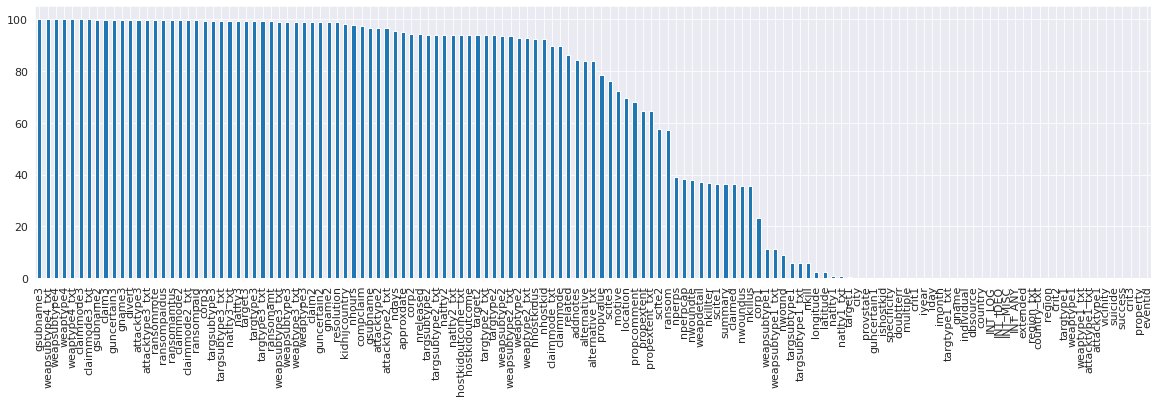

In [11]:
# Percentage of missing values per columns
plt.figure(figsize=(20, 5))
Missing_values_percent = ((GTA_df.isna().sum()/GTA_df.shape[0])*100).sort_values(ascending=False)
Missing_values_percent.plot(kind = 'bar')

In [12]:
print(f'The number of columns which have more than 50% of null values are:{ len(Missing_values_percent [Missing_values_percent >= 50])}')

The number of columns which have more than 50% of null values are:77


In [13]:
## Columns which doesnot contain more than 50% null values
Missing_values_percent [~(Missing_values_percent >= 50)].index

Index(['nperps', 'nperpcap', 'nwoundte', 'weapdetail', 'nkillter', 'scite1',
       'summary', 'claimed', 'nwoundus', 'nkillus', 'corp1', 'weapsubtype1',
       'weapsubtype1_txt', 'nwound', 'targsubtype1', 'targsubtype1_txt',
       'nkill', 'longitude', 'latitude', 'natlty1', 'natlty1_txt', 'target1',
       'city', 'provstate', 'guncertain1', 'ishostkid', 'specificity',
       'doubtterr', 'multiple', 'crit1', 'iyear', 'iday', 'imonth',
       'targtype1_txt', 'gname', 'individual', 'dbsource', 'country',
       'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'extended', 'region_txt',
       'country_txt', 'region', 'crit2', 'targtype1', 'weaptype1',
       'weaptype1_txt', 'attacktype1_txt', 'attacktype1', 'vicinity',
       'suicide', 'success', 'crit3', 'property', 'eventid'],
      dtype='object')

##   **2. Data Cleaning and Manipulations** 
1.   Feature selection <br>
2.   Removing duplicated rows if any <br>
3.   Fixing incorrect values if any <br>
4.   Handling the missing values (multiprocessing applied)<br>
5.   Looking the datatypes
6.   Adding new feature columns if required.<br>

#### **1. Feature Selections**
From the 135 columns Iam considering only following columns for my analyis: 
* eventid -  All the incidents are represented by 12-digit Event ID system 
            • First 8 numbers – date recorded “yyyymmdd”.
            • Last 4 numbers – sequential case number for the given day (0001, 0002 etc).
* iyear - year in which the incident occurred
* imonth - number of the month in which the incident occurred
* iday - day of the month on which the incident occurred
* extended  
        1 = "Yes" The duration of an incident extended more than 24 hours. 
        0 = "No" The duration of an incident extended less than 24 hours.
* country_txt -  country or location where the incident occurred
* region_txt -  region in which the incident occurred (12 regions are here in the data)
* city - name of the city, village, or town in which the incident occurred
* latitude -  latitude (based on WGS1984 standards) of the city where the event occurred
* longitude -  longitude (based on WGS1984 standards) of the city where the event occurred
* success - Success of a terrorist strike is defined according to the tangible effects of the attack
        1 = "Yes" The incident was successful. 
        0 = "No" The incident was not successful
* attacktype1_txt -  general method of attack and often reflects the broad class of tactics used
* targtype1_txt - general type of target/victim
* corp1 - Name of entity that was targeted
* target1 -  specific person, building, installation, etc.that was targeted and/or victimized and is a part of the entity named above
* natlty1_txt - This is the nationality of the target that was attacked, and is not necessarily the same as the  country in which the incident occurred, although in most cases it is. For hijacking incidents, the nationality of the plane is recorded and not that of the passengers
* targsubtype1_txt - The target subtype variable captures the more specific target category and provides the next level of designation for each target type.
* gname - name of the group that carried out the attack
* weaptype1_txt - types of the weapons used in an attack
* nkill -  number of total confirmed fatalities
* nwound - number of confirmed non-fatal injuries to both perpetrators and victims.
* property - Property Damage
        1 = "Yes" The incident resulted in property damage. 
        0 = "No" The incident did not result in property damage.
        -9 = "Unknown"


In [14]:
# Selecting only required features from the above data for further analysis 
keep_cols = ['eventid', 'iyear', 'imonth', 'iday', 'extended','country_txt','region_txt','city', 'latitude',
       'longitude','success','attacktype1_txt', 'targtype1_txt','corp1', 'target1','natlty1_txt','targsubtype1_txt',
       'gname','weaptype1_txt','nkill','nwound','property']

# creating a new dataframe with selected features 
GTA_df_new = GTA_df[keep_cols]

In [15]:
# Renaming the selected columns
GTA_df_new.rename(columns = {'iyear':'year','imonth':'month','iday':'day','country_txt':'country','region_txt':'region',
                           'attacktype1_txt':'attack_type','targtype1_txt':'victim_cata','target1':'specific_victim','targsubtype1_txt':'victim_subtype_cata',
                           'corp1':'entity_name','natlty1_txt':'victim_nationaliy','gname':'perpetrator_group','weaptype1_txt':'weapon','nkill':'num_fatalities',
                           'nwound':'num_injured'},inplace = True)

In [16]:
GTA_df_new.head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,NaN,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,0,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,0,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,0,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),NaN,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,NaN,NaN,1
4,197001000003,1970,1,0,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),NaN,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,NaN,NaN,1


In [17]:
# recheking the shape
GTA_df_new.shape

(181691, 22)

In [18]:
# Describing numeric columns in dataframe (float64 & int64)
GTA_df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
eventid,181691.0,2.002705e+11,1.325957e+09,1.970000e+11,1.991021e+11,2.009022e+11,2.014081e+11,2.017123e+11
year,181691.0,2.002639e+03,1.325943e+01,1.970000e+03,1.991000e+03,2.009000e+03,2.014000e+03,2.017000e+03
month,181691.0,6.467277e+00,3.388303e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
day,181691.0,1.550564e+01,8.814045e+00,0.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.100000e+01
extended,181691.0,4.534622e-02,2.080629e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
latitude,177135.0,2.349834e+01,1.856924e+01,-5.315461e+01,1.151005e+01,3.146746e+01,3.468509e+01,7.463355e+01
longitude,177134.0,-4.586957e+02,2.047790e+05,-8.618590e+07,4.545640e+00,4.324651e+01,6.871033e+01,1.793667e+02
success,181691.0,8.895983e-01,3.133907e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
num_fatalities,171378.0,2.403272e+00,1.154574e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.570000e+03
num_injured,165380.0,3.167668e+00,3.594939e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.191000e+03


In [19]:
# Describing the object columns in the dataframe
GTA_df_new.describe(include = 'object').T

,count,unique,top,freq
country,181691,205,Iraq,24636
region,181691,12,Middle East & North Africa,50474
city,181257,36674,Unknown,9775
attack_type,181691,9,Bombing/Explosion,88255
victim_cata,181691,22,Private Citizens & Property,43511
entity_name,139141,33238,Unknown,16356
specific_victim,181055,86006,Civilians,6461
victim_nationaliy,180132,215,Iraq,24113
victim_subtype_cata,171318,112,Unnamed Civilian/Unspecified,11596
perpetrator_group,181691,3537,Unknown,82782


In [20]:
GTA_df_new.columns

Index(['eventid', 'year', 'month', 'day', 'extended', 'country', 'region',
       'city', 'latitude', 'longitude', 'success', 'attack_type',
       'victim_cata', 'entity_name', 'specific_victim', 'victim_nationaliy',
       'victim_subtype_cata', 'perpetrator_group', 'weapon', 'num_fatalities',
       'num_injured', 'property'],
      dtype='object')

In [21]:
# Exploring unique elements in the selected columns from dataframe
selected_cols = ['year', 'month', 'day', 'extended', 'country', 'region',
               'city', 'success', 'attack_type', 'victim_cata', 'entity_name',
               'specific_victim', 'victim_nationaliy','victim_subtype_cata', 
               'perpetrator_group', 'weapon']
for column_name in selected_cols:
    print(GTA_df_new[column_name].unique())

[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1986 1982
 1983 1984 1985 1987 1988 1989 1990 1991 1992 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017]
[ 7  0  1  2  3  4  5  6  8  9 10 11 12]
[ 2  0  1  3  6  8  9 10 11 12 13 14 15 19 20 21 22 25 26 27 28 30 31  4
  7 16 17 18 23 24  5 29]
[0 1]
['Dominican Republic' 'Mexico' 'Philippines' 'Greece' 'Japan'
 'United States' 'Uruguay' 'Italy' 'East Germany (GDR)' 'Ethiopia'
 'Guatemala' 'Venezuela' 'West Germany (FRG)' 'Switzerland' 'Jordan'
 'Spain' 'Brazil' 'Egypt' 'Argentina' 'Lebanon' 'Ireland' 'Turkey'
 'Paraguay' 'Iran' 'United Kingdom' 'Colombia' 'Bolivia' 'Nicaragua'
 'Netherlands' 'Belgium' 'Canada' 'Australia' 'Pakistan' 'Zambia' 'Sweden'
 'Costa Rica' 'South Yemen' 'Cambodia' 'Israel' 'Poland' 'Taiwan' 'Panama'
 'Kuwait' 'West Bank and Gaza Strip' 'Austria' 'Czechoslovakia' 'India'
 'France' 'South Vietnam' 'Brunei' 'Zaire'
 "People's Repu

* The data includes different years from 1970-2017, except 1993
* There are some incorrect values are present in <code>month</code> and <code>day</code> column

#### **2. Removing duplicated rows if any** 

In [22]:
# Rows containing duplicate values
GTA_df_new[GTA_df_new.duplicated()]

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property


 Great! There are no duplicated rows are present in the dataset.

#### **3. Fixing incorrect values.**

* Both the <code>month</code> and <code>day</code> columns includes value 0
* The <code>city</code> column contains both the 'unknown' and 'Unknown' values. 

In [23]:
# checking out the columns that contains 0 values for day and month 
GTA_df_new[(GTA_df_new.month == 0) | (GTA_df_new.day ==0)].shape

(891, 22)

There are 891 rows are present in the dataset that have 0 values provided for month and day column. 

In [24]:
# Number of unique value counts in both month and day columns
GTA_df_new['month'].value_counts().sort_values(ascending= False),GTA_df_new['day'].value_counts().sort_values(ascending= False)

(5     16875
 7     16268
 8     15800
 10    15563
 6     15359
 3     15257
 4     15152
 1     14936
 11    14906
 9     14180
 2     13879
 12    13496
 0        20
 Name: month, dtype: int64,
 15    6500
 1     6344
 4     6153
 16    6112
 10    6064
 9     6057
 13    6043
 14    6028
 28    6027
 12    6012
 3     6011
 7     5997
 19    5973
 2     5954
 27    5937
 11    5936
 20    5930
 18    5880
 25    5875
 8     5859
 17    5852
 5     5844
 21    5827
 26    5823
 22    5799
 23    5782
 6     5781
 24    5752
 29    5507
 30    5046
 31    3095
 0      891
 Name: day, dtype: int64)

 Replacing the incorrect values with top weighted catagory in the data.

In [25]:
# replacing month 0 values with month 12
GTA_df_new.month.replace(0,5 , inplace = True)

# replacing day 0 values with day 31
GTA_df_new.day.replace(0,15, inplace = True)

In [26]:
# checking the number of both 'Unknown','unknown' & null values in the city column.
print(GTA_df_new[GTA_df_new.city == 'Unknown']['city'].count())
print(GTA_df_new[GTA_df_new.city == 'unknown']['city'].count())
print(len(GTA_df_new[GTA_df_new.city.isna() == True]['city']))

9775
47
434


There are 9775 rows in the <code>city</code> which is named as <mark>'Unknown'</mark> and 47 values for <mark>'unknown'</mark>. So correcting this incorrect values in the data and temporarly replacing all these values including Null values with 'Unknown'.

In [27]:
GTA_df_new.city = GTA_df_new.city.replace('unknown','Unknown')

#### **4. Handling Missing values**

* Null values in the columns <code>num_injured</code> and <code>num_fatalities</code> were filled with forward filling <br>
* Null values in the columns <code>entity_name</code> , <code>specific_victim</code> and <code>victim_nationaliy</code> were replaced wih 'Unknown' <br>
* Null values in the <code>victim_subtype_cata</code> were replaced with 'Unnamed Civilian/Unspecified'<br>
* The possible Null values in the <code>city</code>,<code>longitude</code> and <code>latitude</code> column is found out by using geopy and langid libraries <br>
* Remaining Null values in <code>city</code> replaced with 'Unknown'.<br>
* The remaining Null values in the <code>longitude</code> and <code>latitude</code> columns are dropping out.

In [28]:
# checking the null values in each column in percentage
missing_values = ((GTA_df_new.isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)
missing_values

entity_name            23.418882
num_injured             8.977330
victim_subtype_cata     5.709144
num_fatalities          5.676120
longitude               2.508104
latitude                2.507554
victim_nationaliy       0.858050
specific_victim         0.350045
city                    0.238867
eventid                 0.000000
weapon                  0.000000
perpetrator_group       0.000000
attack_type             0.000000
victim_cata             0.000000
year                    0.000000
success                 0.000000
region                  0.000000
country                 0.000000
extended                0.000000
day                     0.000000
month                   0.000000
property                0.000000
dtype: float64

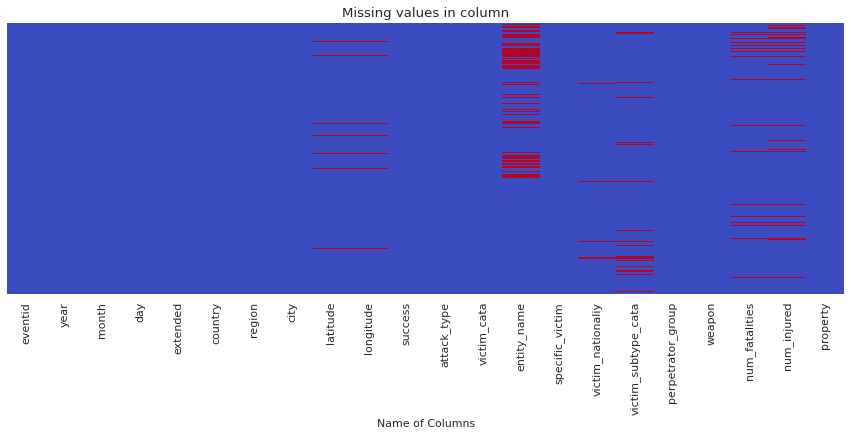

In [29]:
# Visulaizing null values through heatmap.
plt.figure(figsize=(15, 5))
sns.heatmap(GTA_df_new.isnull(), cbar=False, yticklabels=False,cmap='coolwarm')
plt.xlabel("Name of Columns")
plt.title("Missing values in column")
plt.show()

In [30]:
### Filling the missing values 
GTA_df_new[['num_injured','num_fatalities']] = GTA_df_new[['num_injured','num_fatalities']].fillna(method='ffill')
GTA_df_new[['entity_name','specific_victim','victim_nationaliy']] =GTA_df_new[['entity_name','specific_victim','victim_nationaliy']].fillna('Unknown')
GTA_df_new['victim_subtype_cata'] = GTA_df_new['victim_subtype_cata'].fillna('Unnamed Civilian/Unspecified')

In [31]:
# temporarly filling all the missing values in the city column with 'Unknowns'
GTA_df_new['city'] = GTA_df_new['city'].fillna('Unknown')
percent_city_unknown = len(GTA_df_new[GTA_df_new.city =='Unknown'])/len(GTA_df_new)*100

# checking the value counts in city column
GTA_df_new.city.value_counts()

Unknown      10256
Baghdad       7589
Karachi       2652
Lima          2359
Mosul         2265
             ...  
Hotwag           1
Ostend           1
Balughata        1
Jikoyi           1
Kubentog         1
Name: city, Length: 36673, dtype: int64

In [32]:
print(f'The percentage of total "Unknown" values in the city columns {percent_city_unknown}')

The percentage of total "Unknown" values in the city columns 5.644748501576853


Since most of the columns in the <code>city</code> is 'Unknown' values, I am using geopy and langid libraries for finding out the city names by considering non null values from  <code>longitude</code> and <code>latitude</code> columns.

In [33]:
## Finding out the observations where city column is Unknown' ,longitude & latitude values are not null
unknown_city_data = GTA_df_new[(GTA_df_new['longitude'].isna()== False) & (GTA_df_new['latitude'].isna()== False) & (GTA_df_new['city'] == 'Unknown')][['longitude','latitude','city']]
unknown_city_data.head()

,longitude,latitude,city
2,120.599741,15.478598,Unknown
705,49.536102,37.146795,Unknown
1007,-6.086832,54.552254,Unknown
1085,119.583330,23.583333,Unknown
1222,121.965256,17.092014,Unknown


In [34]:
print(f'Total number of observations whose city column is "Unknown" and,latitude and longitude values are not null is: {len(unknown_city_data)}')

Total number of observations whose city column is "Unknown" and,latitude and longitude values are not null is: 7961


#### Multiprocessing for finding out unknown values from city column

In [35]:
# geolocator = Nominatim(user_agent="http")

# def update_city(row):
#     try:
#         Longitude = str(row['longitude'])
#         Latitude = str(row['latitude'])
#         location = geolocator.reverse(Latitude+","+Longitude, exactly_one=True)
#         address = location.raw['address']
#         city = address.get('city', '')

#     ### Selecting the city name only in english language
#         if langid.classify(city)[0] =='en':
#             row['city'] = row['city'].replace('Unknown', str(city))
#         else:
#             row['city'] = row['city']
#         return row
    
#     except Exception as e:
#         print(e)
        
        
# def update_city2(df):
#     df2 = df.apply(update_city , axis = 1)
#     return df2


# df1 = unknown_city_data[0:2000]
# df2 = unknown_city_data[2000:4000]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [36]:
#pd.concat(result,axis =0).to_csv('Geocoder_city.csv')

In [37]:
# df1 = unknown_city_data[4000:6000]
# df2 = unknown_city_data[6000:]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [38]:
#pd.concat(result,axis =0).to_csv('Geocoder_city1.csv')

In [39]:
#Geocoder_data_part1 = pd.read_csv('./Geocoder_city.csv')
#Geocoder_data_part2 = pd.read_csv('./Geocoder_city1.csv')

Geocoder_data_part1 = pd.read_csv('/kaggle/input/output-data/Geocoder_city.csv')
Geocoder_data_part2 = pd.read_csv('/kaggle/input/output-data/Geocoder_city1.csv')

city_data = pd.concat([Geocoder_data_part1,Geocoder_data_part2],axis = 0).set_index('Unnamed: 0')
city_data = city_data[(city_data.city !='Unknown') & (city_data.city.notnull())]

In [40]:
city_data.head()

,longitude,latitude,city
Unnamed: 0,,,
2,120.599741,15.478598,Tarlac City
1007,-6.086832,54.552254,Lisburn
3393,121.972109,6.705778,Isabela
3628,121.972109,6.705778,Isabela
6340,140.717000,-2.533000,Jayapura


In [41]:
### Function for updating the city column in orginal dataframe
def change_city(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['city']] = df2.loc[i,'city'] 
    return df1

In [42]:
change_city(GTA_df_new,city_data).head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [43]:
GTA_df_new.city.value_counts()

Unknown           9949
Baghdad           7589
Karachi           2652
Lima              2362
Mosul             2265
                  ... 
Montalban            1
Enugu Ukwu           1
Sukanguri            1
Fila el Atillo       1
Kubentog             1
Name: city, Length: 36690, dtype: int64

Well! Now the number of 'Unknown' observations in the <code>city</code> column has reduced. But still the method of finding city from latitude and longitudes has not worked well for this data.

In [44]:
((GTA_df_new.isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)

longitude              2.508104
latitude               2.507554
eventid                0.000000
victim_cata            0.000000
num_injured            0.000000
num_fatalities         0.000000
weapon                 0.000000
perpetrator_group      0.000000
victim_subtype_cata    0.000000
victim_nationaliy      0.000000
specific_victim        0.000000
entity_name            0.000000
attack_type            0.000000
year                   0.000000
success                0.000000
city                   0.000000
region                 0.000000
country                0.000000
extended               0.000000
day                    0.000000
month                  0.000000
property               0.000000
dtype: float64

Again I am trying to findout the null values in <code>longitude</code> and <code>latitude</code> by using geopy library considering <code>city</code> , <code>region</code> columns.

In [45]:
### checking out is there any missing values present in lat and long columns where city and region is not null
lat_long_missing = GTA_df_new[(GTA_df_new['longitude'].isna()== True) & 
                             (GTA_df_new['latitude'].isna()== True) & 
                             (GTA_df_new['city']!= 'Unknown') &     
                             (GTA_df_new['country']!= 'Unknown')][['longitude','latitude','city','country']]
len(lat_long_missing)

2261

In [46]:
lat_long_missing.head()

,longitude,latitude,city,country
210,NaN,NaN,Cauayan,Philippines
739,NaN,NaN,Tarlas,Philippines
2400,NaN,NaN,Ghinda,Ethiopia
2941,NaN,NaN,San Juan del Carare,Colombia
3169,NaN,NaN,Cavanilles,Spain


In [47]:
#### General function for finding out latitude and longitude from city and region data.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
def find_lat_long(row):
    try:
        city = str(row['city'])
        country = str(row['country'])
        loc = geolocator.geocode(city+','+ country)
        row['longitude'] = loc.longitude
        row['latitude'] = loc.latitude
        return row
    except:
         pass

In [48]:
#lat_long_missing_df = lat_long_missing.apply(find_lat_long,axis=1)
lat_long_missing_df = pd.read_csv('/kaggle/input/output-data1/lat_long_data.csv')

In [49]:
lat_long_missing_df = lat_long_missing_df[~lat_long_missing_df.longitude.isna()].set_index('Unnamed: 0')
lat_long_missing_df.head()

,longitude,latitude,city,country_name
Unnamed: 0,,,,
210,121.774390,16.933503,Cauayan,Philippines
2400,40.350000,4.200000,Ghinda,Ethiopia
3169,-0.583848,38.619806,Cavanilles,Spain
4941,-0.721047,37.929421,Calla,Spain
5331,-75.537811,9.907504,Barranca,Colombia


In [50]:
lat_long_missing_df.count()

longitude       909
latitude        909
city            909
country_name    909
dtype: int64

In [51]:
# function for updating the orginal dataframe
def replace_missing_lat_long(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['longitude']] = df2.loc[i,'longitude']
            df1.loc[i, ['latitude']] = df2.loc[i,'latitude']
        else:
            pass
    return df1

In [52]:
replace_missing_lat_long(GTA_df_new,lat_long_missing_df).head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [53]:
# Looking the missing values for the latitude and longitude columns
((GTA_df_new[['longitude','latitude']].isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)

longitude    2.007804
latitude     2.007254
dtype: float64

Still the method of finding the latitude and longitude from the city and region data has not made significant difference in this data. This is because of some strings in <code>city</code> or <code>region</code> columns are not in standardized spelling. But however above two methodes was worked well for some part of data. <br>
I am using what ever the values that I could findout through the above function. Remaing 2 percentage of latitude and longitude unknown values are dropping out from the data. 

In [54]:
# Dropping remaining missing values in latitude and longitude
GTA_df_new = GTA_df_new.dropna()

#### **5. Looking the datatypes of columns**
* The datatypes of <code>num_fatalities</code> and <code>num_injured</code> is changing to int64

In [55]:
GTA_df_new.dtypes

eventid                  int64
year                     int64
month                    int64
day                      int64
extended                 int64
country                 object
region                  object
city                    object
latitude               float64
longitude              float64
success                  int64
attack_type             object
victim_cata             object
entity_name             object
specific_victim         object
victim_nationaliy       object
victim_subtype_cata     object
perpetrator_group       object
weapon                  object
num_fatalities         float64
num_injured            float64
property                 int64
dtype: object

In [56]:
GTA_df_new = GTA_df_new.astype({'num_fatalities':'int64','num_injured':'int64'})

#### **6. Creating new feature column**
Creating a new column <code>num_casualities</code> by adding <code>num_fatalities</code> and <code>num_injured</code>


In [57]:
GTA_df_new['num_casualities'] = GTA_df_new['num_fatalities']+ GTA_df_new['num_injured']

#### Checking out the relationships between 'property','num_casualities' and 'success' columns.
##### (Continue from 3. Fixing incorrect values.)<br>
I am explicitly checking whether any observations are present in the data with the following conditions:<br>
<code>num_casualities == 0 & property == 0 & success ==1</code> <br>
Such columns are considered incorrect values. If any such columns are present in the data we may have to do some further treatment for wrong values. An attack is reported as successful only when either the perpetrator is succeed in damaging the targeted property or attacking the targetd victims 


Text(0.5, 1.0, 'Types of property damage during attacks')

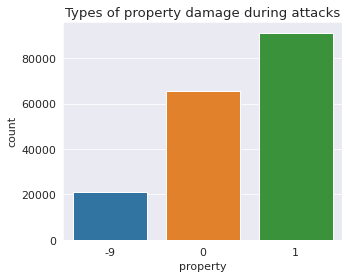

In [58]:
plt.figure(figsize=(5,4))
sns.countplot('property', data=GTA_df_new)
plt.title('Types of property damage during attacks')

There are near 65000 incidents are recored in the data which clearly doesnt make any property damages.

In [59]:
# There are several incidents which doesnt cause to any casualities 
zero_casuality_attack=  GTA_df_new[GTA_df_new.num_casualities == 0]
zero_casuality_attack['eventid'].count()

65804


There are 65804 data are reported which didn't lead to caualities. Again checking howmany of them  doesn't cause any property damage?

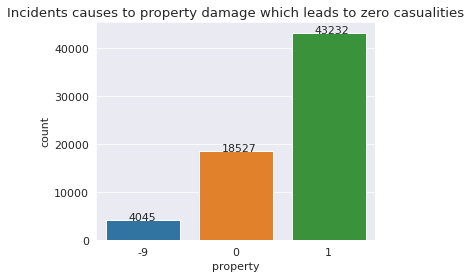

In [60]:
plt.figure(figsize=(5,4))
ax = sns.countplot('property', data=zero_casuality_attack)
plt.title('Incidents causes to property damage which leads to zero casualities')

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [61]:
non_harm_attack = zero_casuality_attack[zero_casuality_attack.property == 0]
non_harm_attack['success'].value_counts()

0    10716
1     7811
Name: success, dtype: int64

There are 18527 attacks took place which doesn't cause any casualities and property damages. But among these data 7811 attacks are recorded as successful. 
Which means 7811 recores reported as successful which causes 0 casualities and  0 property damages. In such cases we are checking the types of wepon used.


In [62]:
GTA_df_new.loc[(GTA_df_new.property == 0) & 
               (GTA_df_new.num_casualities == 0) & 
               (GTA_df_new.success == 1)]['weapon'].value_counts()

Explosives            2797
Unknown               2534
Firearms              2281
Melee                   87
Incendiary              81
Fake Weapons            16
Chemical                 9
Other                    4
Sabotage Equipment       2
Name: weapon, dtype: int64

In both the explosives and firearms cases, most probabily there can be property damages, wounds even deaths can be occur. But in this data I am considering only property damages.

In [63]:
# Updating the property damages in the above foundout columns
GTA_df_new['property'] = np.where(((GTA_df_new.property == 0)& 
                              (GTA_df_new.num_casualities == 0) & 
                              (GTA_df_new.success == 1)),1,GTA_df_new.property)

Text(0.5, 1.0, 'Types of property damage during attacks')

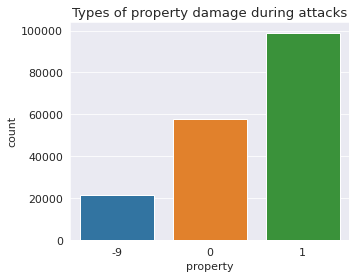

In [64]:
# cheking the property damage column again for confirming the data frame has updated.
plt.figure(figsize=(5,4))
sns.countplot('property', data=GTA_df_new)
plt.title('Types of property damage during attacks')

Great! Now the values has been updated.

In [65]:
### distinct countries exist in each region of the dataset
region_country_df = GTA_df_new[['region','country']]
region_df = region_country_df.groupby('region').agg(set)

def count_counties(row):
  row['unique_country_count'] = len(row['country'])
  return row

region_df_1 = region_df.apply(count_counties, axis = 1)
region_df_1

,country,unique_country_count
region,,
Australasia & Oceania,"{Fiji, Australia, Wallis and Futuna, Solomon I...",10
Central America & Caribbean,"{Barbados, Guadeloupe, Antigua and Barbuda, Ho...",21
Central Asia,"{Turkmenistan, Azerbaijan, Kazakhstan, Kyrgyzs...",8
East Asia,"{South Korea, Macau, Hong Kong, North Korea, T...",7
Eastern Europe,"{Serbia-Montenegro, Lithuania, Serbia, Bulgari...",26
Middle East & North Africa,"{Algeria, Libya, Iraq, Morocco, Lebanon, Syria...",23
North America,"{Canada, Mexico, United States}",3
South America,"{Bolivia, Colombia, Falkland Islands, Uruguay,...",14
South Asia,"{Mauritius, Afghanistan, Maldives, India, Bang...",9


#### **6. Correlation Plot**

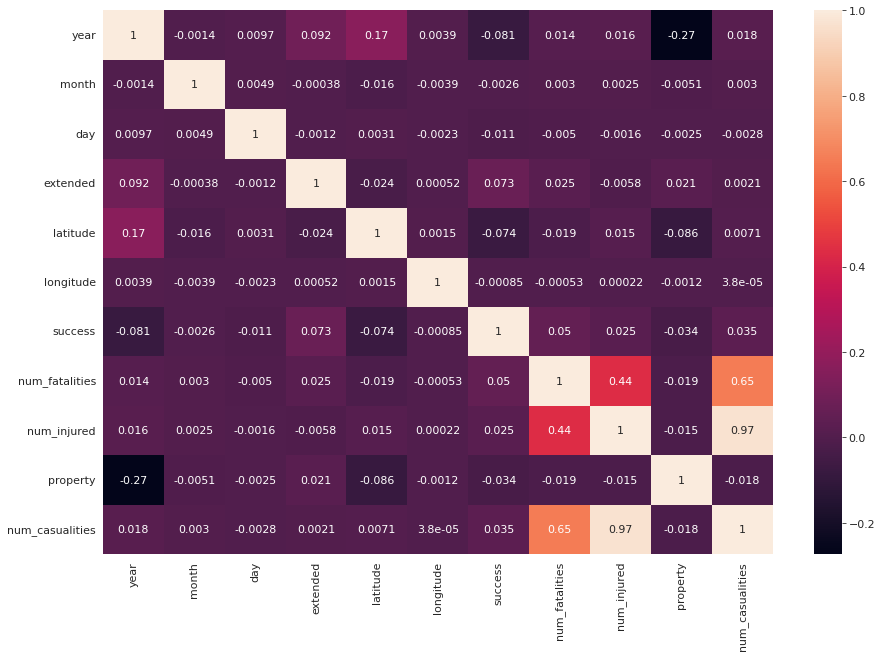

In [66]:
plt.figure(figsize=(15,10))
sns.heatmap(GTA_df_new.drop('eventid',axis = 1).corr(), annot= True)
plt.show()

* <code>num_fatalities</code> and <code>num_casualities</code> are moderately correlated. This meas with increase in fatality number the total casualities are also increases.

## **3. Exploratory Data Analysis & Visualizations**
### **Univariate Analysis | Bivariate Analysis |  Multivariate Analysis**

### 1. Identify the trend in attack over the years. Which year had the highest & lowest number of attacks?

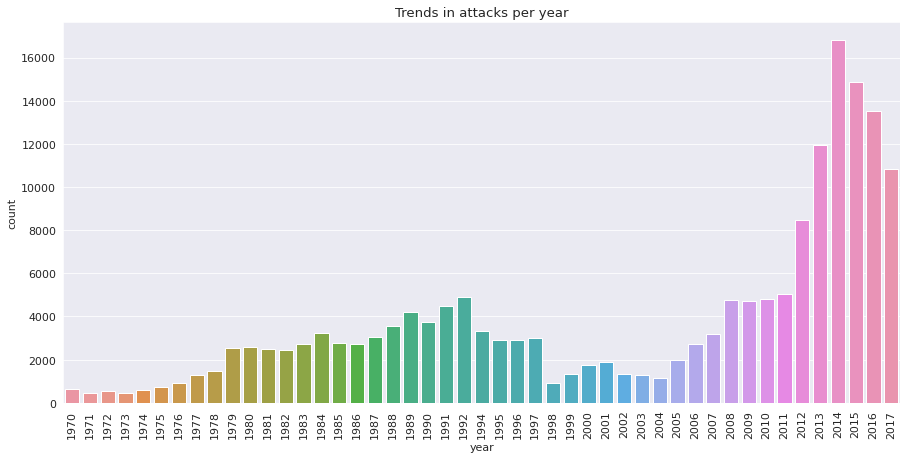

In [67]:
plt.figure(figsize=(15,7))
sns.countplot(x=GTA_df_new.year)
plt.title('Trends in attacks per year')
plt.xticks(rotation = 90)
plt.show()

##### **Findings from the above graph**
* The period <code>2013 - 17</code>  had the <code>highest</code> period of attacks per year (>10,000). 
* Year <code>2014 had the most number of attacks</code>(<16000).
* The period <code>1970 - 76</code> shows the <code>lowest</code> period of attacks (>1000). 
* <code>1971 and 1973</code> shows the <code>lowest numbers</code> of attacks.

### 2. What percentage of total attacks had extended more than 24 hours?

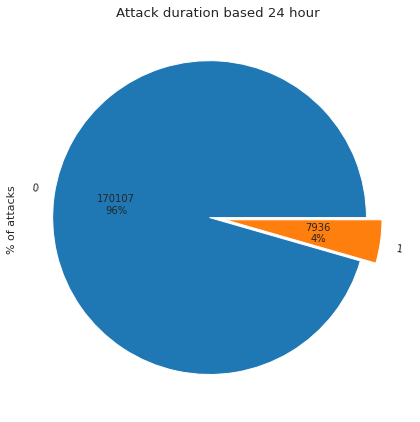

In [68]:
# Function for customised labelling 
def label_function(val):
    return f'{val / 100 * len(GTA_df_new):.0f}\n{val:.0f}%'

# Ploting the values
plt.figure(figsize=(6,6))
GTA_df_new.groupby('extended').size().plot(kind='pie',
                                 autopct=label_function,
                                 textprops={'fontsize': 10},explode=[0.05]*2,
                                 rotatelabels=True , 
                                 title = 'Attack duration based 24 hour')
plt.tight_layout()
plt.ylabel('% of attacks')
plt.show()

##### **Findings from the above graph**
<code>Only 4% of attacks only extendended more than 24 hours</code>. In numbers it counted below 8000.

### 3. Percentage of successful and unsuccessful attacks

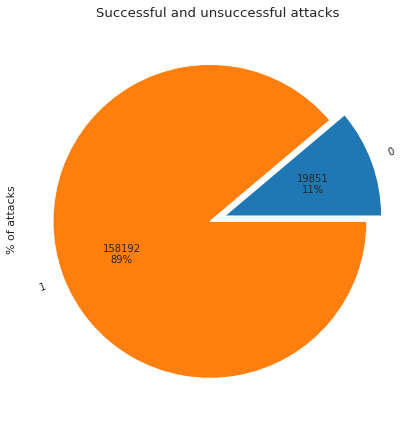

In [69]:
# Ploting the values
plt.figure(figsize=(6,6))
GTA_df_new.groupby('success').size().plot(kind='pie',
                                 autopct=label_function,
                                 textprops={'fontsize': 10},explode=[0.05]*2,
                                 rotatelabels=True,
                                 title = 'Successful and unsuccessful attacks')
plt.tight_layout()
plt.ylabel('% of attacks')
plt.show()

##### **Findings from the above graph**
* <code> 89% </code>of total attacks happended all over the world during the period of time 1970 -2017 were reported as successful. 

### 4. Do the trend in attacks varies with respect to a particular month?

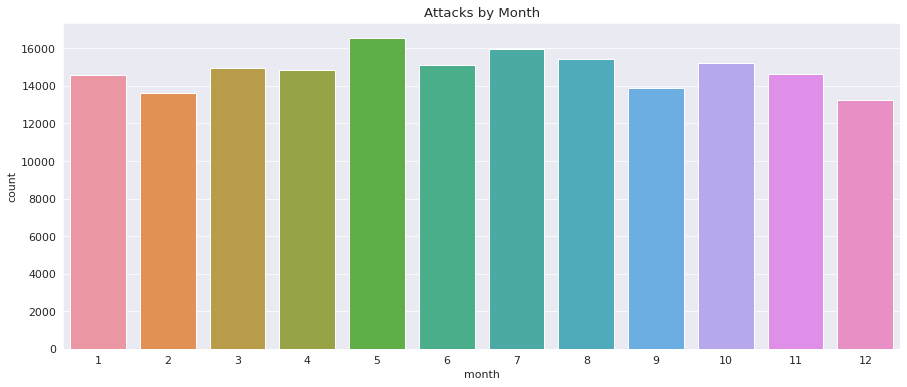

In [70]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'month',data=GTA_df_new)
plt.title('Attacks by Month')
plt.show()

##### **Findings from the above graph**
* Almost every month has the same contribution

### 5. According to the data, which are the top 25 countries currently at risk of increased terrorist activity? Discuss the activities in the countries over the years

In [71]:
# Creating dataframe of targeted countries
target_countries = GTA_df_new.groupby('country').eventid.count().sort_values(ascending=False)[:25].to_frame()

# Plotting values
country_plot = [{
        'x': target_countries.index,
        'y': target_countries['eventid'].values,
        'mode': 'markers',
        'marker': {
                   'sizemode': 'area',
                   'size': target_countries['eventid'].values}
                                                   }]
iplot(country_plot)

##### **Findings from the above graph**
* <code>Iraq </code> is the <code>most targeted</code> country in the history. 
* <code>followed by Pakisthan, Afganisthan and India</code>.
* <code>Iraq</code> is the <code>only one</code> country which was attacked <code>more than 24,500 times</code> in the history. 
* Pakisthan, Afganisthan and India are attacked more than 10,000 times during 1970 -2017.
* Number of attacks had in Philippines + Peru = Number of attacks had in Afganisthan.
* Since the countries with the highest attacks are the mostly <code>densely populated</code>, the attacks in these countries may <code>claim more damages and lives</code>.

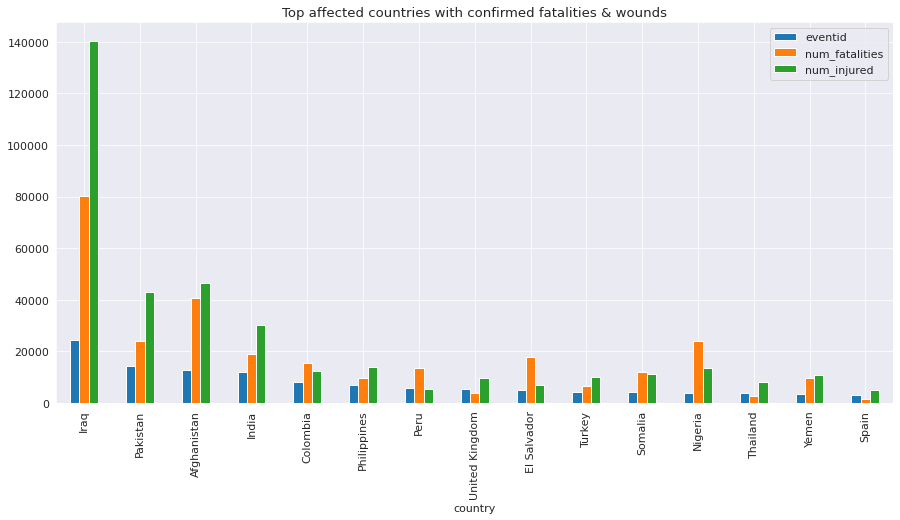

In [72]:
# Plotting the wounds and deaths per attacks (checking only top 10 countries)
GTA_df_new.groupby(['country']).agg({'eventid':'count',
                                     'num_fatalities':'sum',
                                    'num_injured':'sum'
                                    }).sort_values(by ='eventid', 
                                                   ascending= False)[:15].plot(kind = 'bar',
                                                                              figsize=(15, 7))
plt.title('Top affected countries with confirmed fatalities & wounds')
plt.show()

* The confirmed fatalities in Iraq is 3 times larger than number of attacks & confirmed wounds are 6 times larger than number of attacks.
* In Nigeria the confirmed fatalities are 6-folds larger than the number of attacks.

### Death tolls with respect to year, country & region

In [73]:
# Death tolls with respect to year, country & region

fig = px.treemap(GTA_df_new, path=[px.Constant("Global terrorism(Countries/Years) - size is proportional with the number of fatalities"), 
                                   'country', 'year'], 
                            values='num_fatalities',
                            color='region', 
                            hover_data=['region'],
                  color_continuous_scale='Inferno')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

##### **Findings from the above graph**
* Iraq, Afghanistan,Pakistan,Nigeria & Syria are severly victimised after 2012. <br> These deadliest periods are famously known by: 
 1. Syrian Civil War - 2014,2015 & 16 showing higher number of deaths. 
 2. Iraq War  - Btw. 2013 -16 the above graph shows the evidence of higher number of fatalities compared to other time periods.<br> Aprox. 54% of overall attacks happeded in the country was from this time period.
 3. Afghanistan War - Between 2012 - 16 is showing higher number of fatalities Afghanistan.
 4. The War Against Boko Haram - Nigeria was victimized mostly after 2010. They had higher number of attacks in 2014 followed by 2015. 
 
* El Salvador faced noxious attack during 1980 - 83 periods.This was the early periods of Salvadoran Civil War.

### 10. Top victimized countries Versus Rest of the world

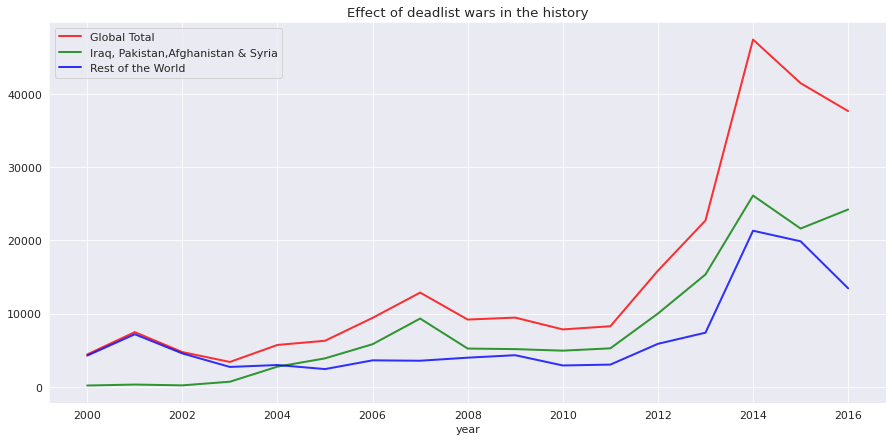

In [74]:
after_2000_df = GTA_df_new[GTA_df_new['year'].between(2000, 2016)]

top_wars_df = after_2000_df[(after_2000_df.country =='Iraq')|
                       (after_2000_df.country =='Pakistan')|
                       (after_2000_df.country =='Afghanistan')|
                       (after_2000_df.country =='Syria')]

remaining_world_df = after_2000_df[(after_2000_df.country !='Iraq')&
                       (after_2000_df.country !='Pakistan')&
                       (after_2000_df.country !='Afghanistan')&
                       (after_2000_df.country !='Syria')                                 ]

### plotting the data

plt.figure(figsize=(15, 7))
ax1 = plt.subplot(111)
after_2000_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                           ax=ax1,
                                                           color = 'red',alpha = 0.8,
                                                           sharex = True,
                                                           sharey = True,
                                                           linewidth=2,
                                                          label = 'Global Total')
top_wars_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                         color = 'green',
                                                         ax=ax1,alpha = 0.8,
                                                         sharex = True,
                                                         sharey = True,
                                                         linewidth=2 ,
                                                        label = 'Iraq, Pakistan,Afghanistan & Syria')
remaining_world_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                                linewidth=2 ,
                                                                ax=ax1,
                                                                sharex = True,
                                                                sharey = True,
                                                                color = 'blue',alpha = 0.8,
                                                               label = 'Rest of the World')
plt.title('Effect of deadlist wars in the history')
plt.legend()
plt.show()

##### **Findings from the above graph** 
* After 2005 , over 50% of global attacks are reported from from Iraq,Pakistan,Afghanistan and Syria.
* In 2007, approx.72% of attacks had been reported from Iraq,Pakistan,Afghanistan and Syria combined.

In [75]:
(top_wars_df.groupby('year')['num_fatalities'].sum()
 /after_2000_df.groupby('year')['num_fatalities'].sum())*100

year
2000     3.695307
2001     3.914209
2002     3.890886
2003    20.141970
2004    48.063103
2005    61.675693
2006    61.719996
2007    72.410575
2008    56.778553
2009    54.406780
2010    62.923215
2011    63.451531
2012    63.041696
2013    67.514746
2014    55.064612
2015    52.102117
2016    64.306957
Name: num_fatalities, dtype: float64

### 6. Top 50 targeted cities in the history

In [76]:
target_cities = GTA_df_new[GTA_df_new.city != 'Unknown'].groupby(['city'])['eventid'].count().sort_values(ascending= False)[:50].to_frame()

# Plotting
data = [{
        'x': target_cities.index,
        'y': target_cities['eventid'].values,
        'mode': 'markers',
        'marker': {
            'sizemode': 'area',
            'size': target_cities['eventid'].values}
                                                   }]
iplot(data)

##### **Findings from the above graph**
* The capital of Iraq, the second larget city in the Arab world <code>Baghdad was the most targeted</code> city in the world.
* Followed by Karachi in Pakisthan ,Lima in Peru,Mosul and Belfast are victimised more tha 2000 times.
* Baghdad alone was targeted more than 7,500 times in the history.
* Karachi,Lima and Mosul combined had less than 7,500 attacks.

### 7. Top 10 active terrorist groups in the most affected city (Baghdad, Karachi & Lima)

In [77]:
# top targeted groups in Baghdad
baghdad_df = GTA_df_new[GTA_df_new.city == 'Baghdad']
baghdad_df.groupby('perpetrator_group')['eventid'].count().sort_values(ascending = False)[:5]

perpetrator_group
Unknown                                        6535
Islamic State of Iraq and the Levant (ISIL)     622
Al-Qaida in Iraq                                216
Islamic State of Iraq (ISI)                      57
Tawhid and Jihad                                 22
Name: eventid, dtype: int64

### 8. Trends of attack in top affected city (Baghdad) in each year.

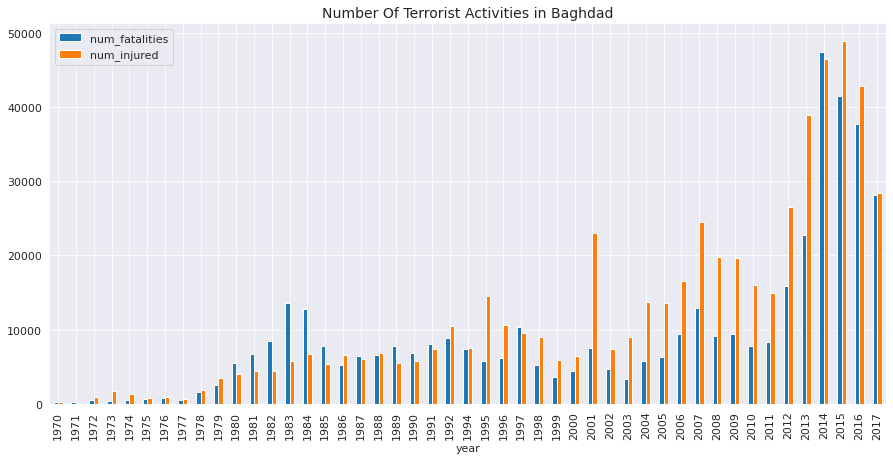

In [78]:
baghdad_casualities = GTA_df_new.groupby('year')['num_fatalities','num_injured'].sum()
baghdad_casualities.plot(kind='bar',figsize=(15, 7))
plt.title('Number Of Terrorist Activities in Baghdad',size = 14)
plt.show()

##### **Findings from the above graph combined with the war history**
* In  Baghdad, the priod <code>2011 - 17 had higher number of fatalities and wounds</code>.The city has faced severe damages during this time due to the <code>Iraq War</code> which is lasted  until 2011 and subsequent insurgency and renewed war that lasted until 2017.
* The attacks started <code>declining from 2017</code> manily because of <code>territorial defeat of the Islamic State militant group.</code>
* From <code>2003 - 2011</code> is showing up & down trend in attack due to <code>United States invasion of Iraq</code> lasted from 2003-11.

### 9. Deaths, wounds and total casualties with respect to the Global trends.

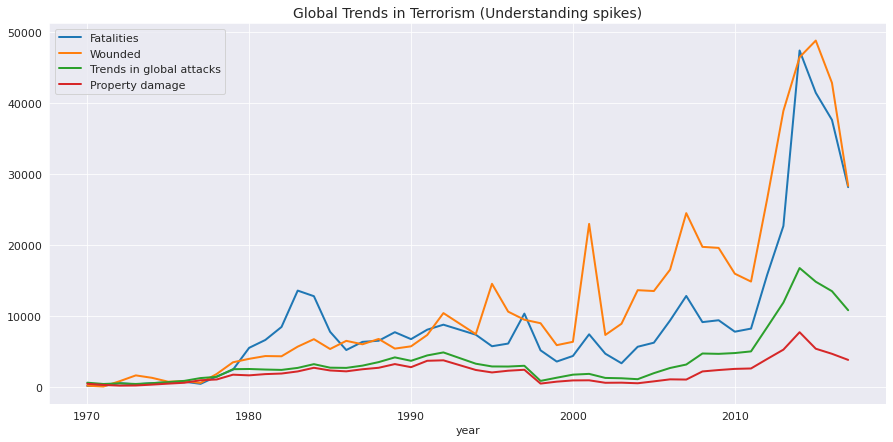

In [79]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(111)
plt.title('Global Trends in Terrorism (Understanding spikes)', size = 14)

GTA_df_new.groupby('year')['num_fatalities'].sum().plot(linewidth=2,
                                                        ax=ax1,
                                                        sharex = True,
                                                        sharey = True,
                                                        label = 'Fatalities')

GTA_df_new.groupby('year')['num_injured'].sum().plot(linewidth=2,
                                                     ax=ax1,
                                                     sharex = True,
                                                     sharey = True,
                                                     label = 'Wounded' )

GTA_df_new.groupby('year')['eventid'].count().plot(linewidth=2,
                                                   ax=ax1,
                                                   sharex = True,
                                                   sharey = True,
                                                   label = 'Trends in global attacks')

GTA_df_new[GTA_df_new.property  == 1].groupby('year')['property'].sum().plot(linewidth=2, 
                                                                             ax=ax1,
                                                                             sharex = True,
                                                                             sharey = True,
                                                                             label = 'Property damage')
plt.legend()
plt.show()

##### **Findings from the above graph**
* The number of attacks started increased substantially since 2013, causing a significant increase in the number of confirmed fatalities, wounds, and property damages compared to earlier periods.
* Compared to 2012, 2013 has 40% increase in activities, 43% increase in cofirmed fatalities & 46% of increase in confirmed wounds.
* The year 2014 witnessed a number of fatalities. ie approx.10-fold increase as compared to the early 20s. 47437 confirmed fatalities with 46490 wounds from 16796 attacks over the globe in 2014.
* The attacks in 2015 causes highest number of confirmed wouds ie. 41482

### 11. Compare the terror attack trend in each regions

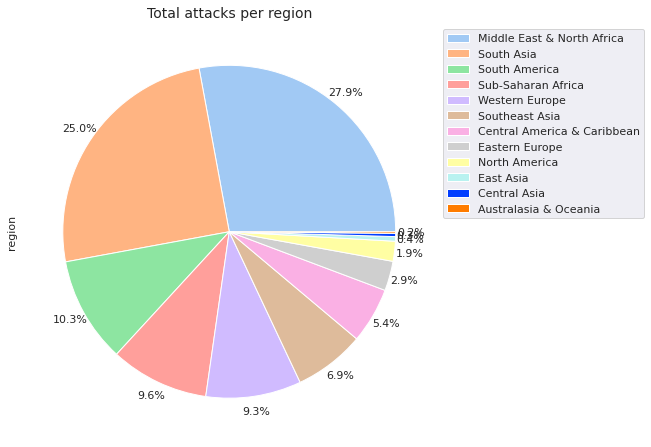

In [80]:
plt.figure(figsize=(9, 9))
colors = sns.color_palette('pastel')[0:10]+sns.color_palette('bright')[0:2]
GTA_df_new.region.value_counts().plot(kind='pie',
                                      autopct="%.1f%%",
                                      pctdistance= 1.09, 
                                      colors = colors,
                                      labels = None,
                                      rotatelabels=True,
                                      labeldistance=1)
plt.legend(labels =GTA_df_new.region.value_counts().index, 
                                                    bbox_to_anchor = (1,1),
                                                    loc = 2)
plt.title('Total attacks per region',size = 14)
plt.tight_layout()
plt.show()

##### **Findings from the above graph**
* The regions <code>Middle East & North Africa and South Asia</code> combinely cover <code>more than 52% </code>of attacks happended all over the world.
* <code>Middle East & North Africa</code> was the <code>top targeted</code> region in the history.
* <code>East Asia ,Central Asia and Australasia & Oceania combinely contribute only < 1% of attacks</code> happended all over the world. 
* The region <code>Australasia & Oceania</code> is the <code>lowest targeted</code> region in the history.

### 12. The total num. of fatalities, injured and casualties by Region

In [81]:
data_by_region = GTA_df_new.groupby('region')['num_fatalities','num_injured','num_casualities'].sum()
data_by_region 

,num_fatalities,num_injured,num_casualities
region,,,
Australasia & Oceania,162,273,435
Central America & Caribbean,36183,12471,48654
Central Asia,946,1932,2878
East Asia,1176,9257,10433
Eastern Europe,8293,12586,20879
Middle East & North Africa,142528,226677,369205
North America,5023,21650,26673
South America,32184,20916,53100
South Asia,102236,145154,247390


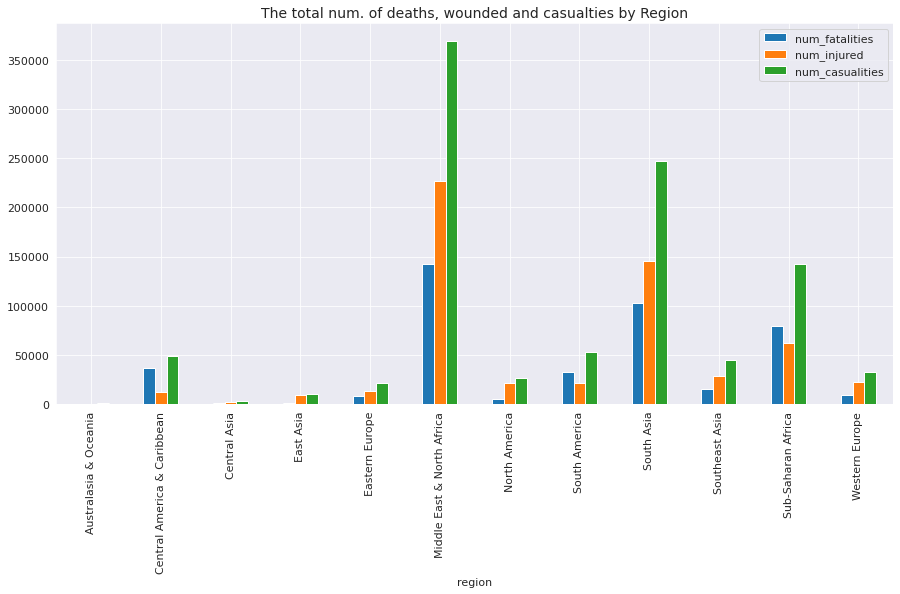

In [82]:
data_by_region.plot(kind = 'bar',figsize=(15, 7))
plt.title('The total num. of deaths, wounded and casualties by Region',size = 14)
plt.show()

##### **Findings from the above graph**
* Middle East and North Africa had the highest counts of death ,wounded and casualties. (ie, more than 140000 deaths,220000 wounds and 369000 casualities in total)
* Followed by South Asia and Sub-Sahran Africa.
* There are only above mentioned three regions that had more than 100000.
* Australasia & Oceania had the least number of casualities (<500).
* Australasia & Oceania and Central Asia had number of fatalities below 1000.

### 13. Attacks by region and year

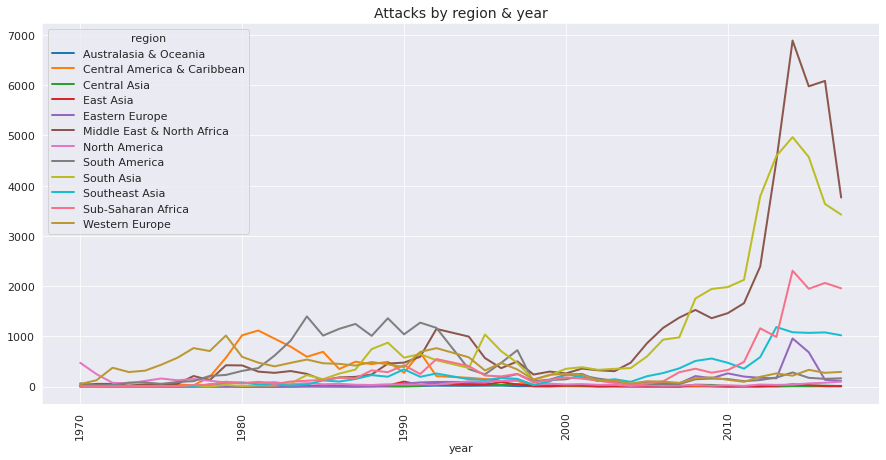

In [83]:
colors = sns.color_palette()[0:10]+ sns.color_palette('husl')[0:2]
pd.crosstab(GTA_df_new.year, GTA_df_new.region).plot(
                                                     kind='line',
                                                     stacked=False,
                                                     figsize=(15,7),
                                                     color = colors,
                                                     linewidth=2,
                                                     rot = 90)
plt.title('Attacks by region & year',size = 14)
plt.show()

##### **Findings from the above graph**
* Australasia & Oceania ,East Asia ,Central Asia are the regions that maintains low attacks during 1970-2017.This is because these regions may have most active counter-terror units to protect their citizens.
* Eastern Europe, Southeast Asia, Sub-Saharan Africa, South Asia and Middle East & North Africa were the top victims attacks after 2010. 
* None of the regions had not cross more than 1500 attaks before 2000.
* South America,Central America & Caribbean,Western Europe,Middle East & North Africa were the most fallen victim of attacks before 2000.
* South Asia and Middle East & North Africa had spike in 2014 when South Asia crossed approx. 4900 attacks & Middle East & North Africa crossed approx. 6800 attacks.

### 

### 14. Number of Successful and Unsuccessful attacks per year

In [84]:
plt.rcParams['figure.figsize'] = (15, 7)
fig = px.histogram(GTA_df_new, 
                   x='year', 
                   color = 'success', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Number of terrorist attack per year')
fig.update_layout(bargap=0.1)
fig.update_xaxes(tickangle= -90)
fig.show()

### 15. Methodes of attacks by count 

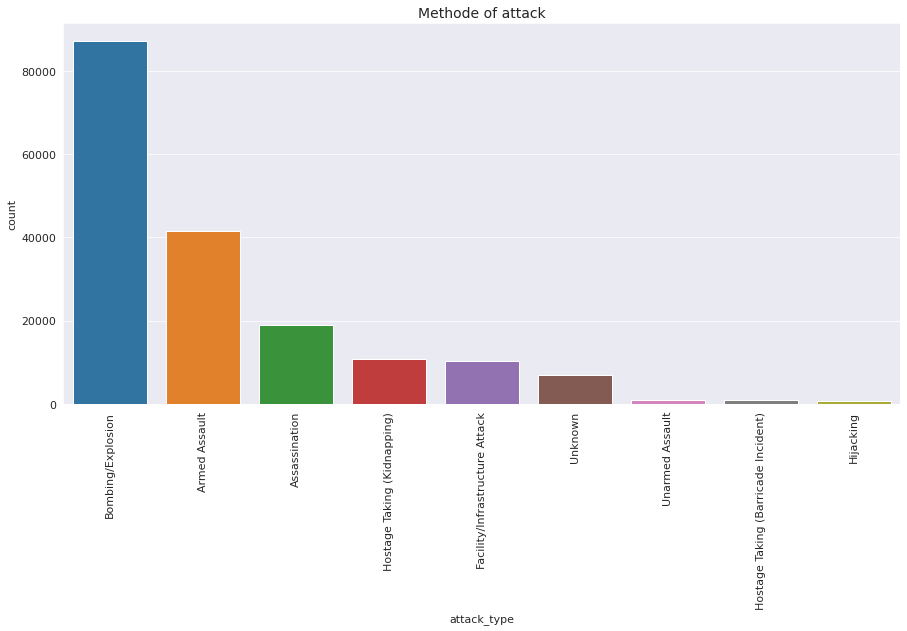

In [85]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(x="attack_type", data= GTA_df_new, order=GTA_df_new.attack_type.value_counts().index)
plt.title('Methode of attack', size = 14)
plt.xticks(rotation=90)
plt.show()

##### **Findings from the above graph**
* Bombing/Explosion was the most prevalent method of attack that covered 49% of global attacks.
* Followed by Armed Assault and Assassination
* Hijacking,Unarmed Assault and Hostage Taking were the rare methods of attack (covers <1% of global attacks).
* Hijacking, Hostage Taking (Barricade Incident), and Unarmed Assault combined covers only 1.5% of global attacks.

### 16. Victims of Terrorist attacks

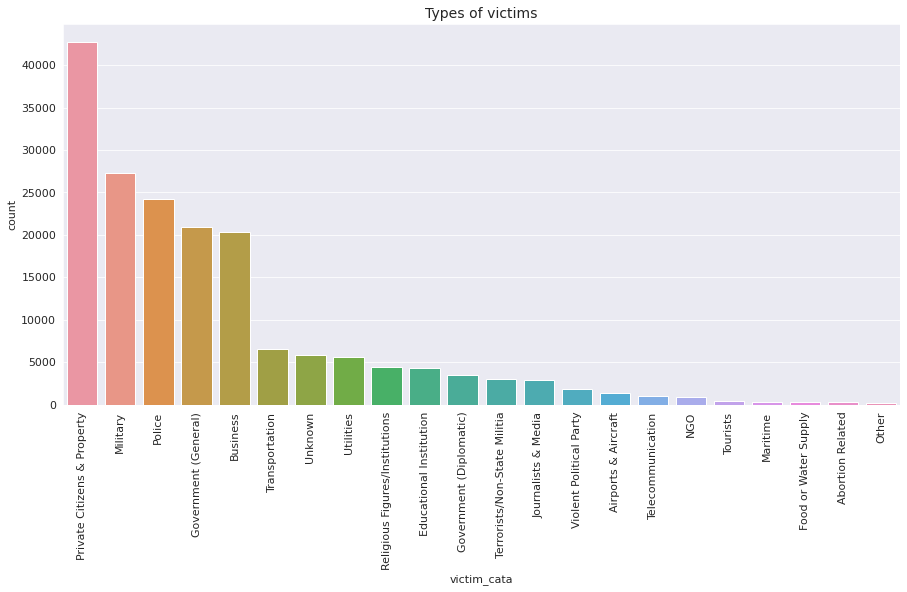

In [86]:
### types of victims of attack
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(x="victim_cata", data= GTA_df_new, order=GTA_df_new.victim_cata.value_counts().index)
plt.title('Types of victims', size = 14)
plt.xticks(rotation=90)
plt.show()

In [87]:
GTA_df_new.victim_cata.value_counts()/len(GTA_df_new)*100

Private Citizens & Property       23.990834
Military                          15.295182
Police                            13.618059
Government (General)              11.750532
Business                          11.425891
Transportation                     3.694613
Unknown                            3.277860
Utilities                          3.146993
Religious Figures/Institutions     2.468505
Educational Institution            2.401105
Government (Diplomatic)            1.975927
Terrorists/Non-State Militia       1.674315
Journalists & Media                1.606354
Violent Political Party            1.034020
Airports & Aircraft                0.737462
Telecommunication                  0.562224
NGO                                0.529647
Tourists                           0.237583
Maritime                           0.178609
Food or Water Supply               0.169622
Abortion Related                   0.147717
Other                              0.076948
Name: victim_cata, dtype: float6

### 17. Top 25 active terror groups in history

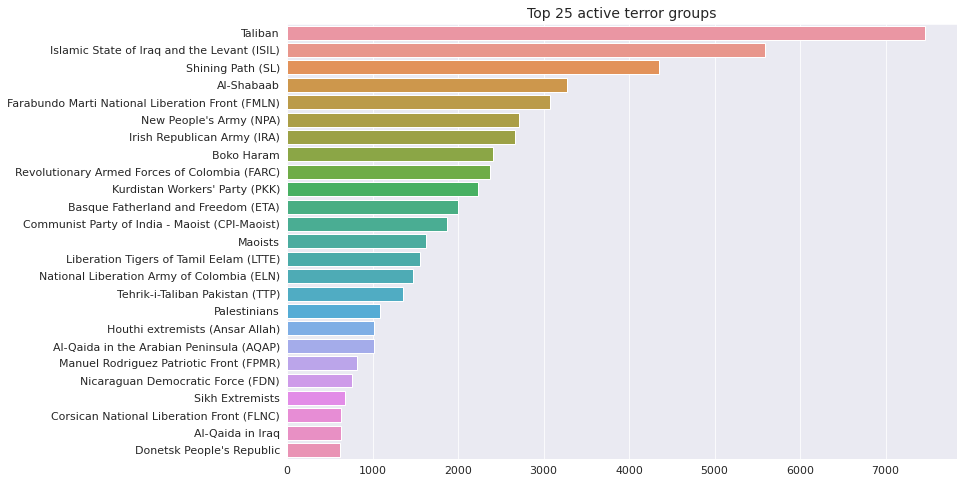

In [88]:
plt.rcParams['figure.figsize'] = (12, 8)
active_groups = GTA_df_new[GTA_df_new['perpetrator_group'] !='Unknown']
sns.barplot(active_groups['perpetrator_group'].value_counts()[:25].values,active_groups['perpetrator_group'].value_counts()[:25].index)
plt.title('Top 25 active terror groups', size = 14)
plt.show()

In [89]:
(GTA_df_new['perpetrator_group'].value_counts()/len(GTA_df_new)*100)[:25]

Unknown                                             45.856338
Taliban                                              4.188876
Islamic State of Iraq and the Levant (ISIL)          3.136321
Shining Path (SL)                                    2.439860
Al-Shabaab                                           1.840567
Farabundo Marti National Liberation Front (FMLN)     1.725426
New People's Army (NPA)                              1.524351
Irish Republican Army (IRA)                          1.495144
Boko Haram                                           1.352482
Revolutionary Armed Forces of Colombia (FARC)        1.336194
Kurdistan Workers' Party (PKK)                       1.252506
Basque Fatherland and Freedom (ETA)                  1.122201
Communist Party of India - Maoist (CPI-Maoist)       1.053678
Maoists                                              0.913824
Liberation Tigers of Tamil Eelam (LTTE)              0.875070
National Liberation Army of Colombia (ELN)           0.829013
Tehrik-i

##### **Findings from the above graph**
* Taliban was the most active group in history. Around 4% of global attacks were led by the Taliban alone.
* Followed by ISIL at second rank with 3% of global attacks and Shining Path(SL) at third rank with 2.4% of global attacks.

### 18. Attacks by top 3 ranked groups over the years

In [90]:
Top_3_groups_df = GTA_df_new[(GTA_df_new['perpetrator_group'] =='Taliban')|
           (GTA_df_new['perpetrator_group'] =='Islamic State of Iraq and the Levant (ISIL)')|
           (GTA_df_new['perpetrator_group'] =='Shining Path (SL)')]
plt.rcParams['figure.figsize'] = (15, 7)

fig = px.histogram(Top_3_groups_df, 
                   x='year', 
                   color = 'perpetrator_group', 
                   title='Attacks by top 3 ranked groups')

fig.update_layout(bargap=0.1)
fig.update_xaxes(tickangle= -90)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1),
    bargap=0.1)

fig.show()

##### **Findings from the above graph**
* First attack of Shining Path(SL) was in 1978.
* Shining Path(SL) has grown into the deadliest terror group by doing several attacks during 1980-1997.
* After 1992, there is a significant reduction in attacks initiated by SL lowering from 277 to 73.
* Shining Path(SL) has done more than 400 attacks during the years 1983,1984,1987,1989 and 1991.
* In 1989 they have done 494 attacks which were the top attacks done by them in a year.
* ISIL has done their first attack in 2013 and in the same year, they have done 370 attacks.
* From 2013 -17 they have done more than 1000 attacks in a year.
* Taliban’s first attack was in 1995.
* After that there is an  exponential growth of the attacks by them during 2003-17


### 19. Top 3  acive groups and their countries 

In [91]:
df = Top_3_groups_df.groupby(['perpetrator_group','country']).agg({'eventid':'count','num_fatalities':'sum',
                                                                     'num_injured':'sum',
                                                                      'year':set})
df = df.sort_values('eventid',ascending= False)
df.head()

eventid  \
perpetrator_group                           country                
Taliban                                     Afghanistan     7403   
Islamic State of Iraq and the Levant (ISIL) Iraq            4781   
Shining Path (SL)                           Peru            4331   
Islamic State of Iraq and the Levant (ISIL) Syria            584   
                                            Turkey            82   

                                                         num_fatalities  \
perpetrator_group                           country                       
Taliban                                     Afghanistan           30342   
Islamic State of Iraq and the Levant (ISIL) Iraq                  32418   
Shining Path (SL)                           Peru                  12103   
Islamic State of Iraq and the Levant (ISIL) Syria                  7352   
                                            Turkey                  416   

                                                         num_injured  \
perpetrator_group                           country                    
Taliban                                     Afghanistan        29598   
Islamic State of Iraq and the Levant (ISIL) Iraq               25381   
Shining Path (SL)                           Peru                4195   
Islamic State of Iraq and the Levant (ISIL) Syria               4881   
                                            Turkey              1274   

                                                                                                      year  
perpetrator_group                           country                                                         
Taliban                                     Afghanistan  {2016, 2017, 1995, 2001, 2002, 2003, 2004, 200...  
Islamic State of Iraq and the Levant (ISIL) Iraq                            {2016, 2017, 2013, 2014, 2015}  
Shining Path (SL)                           Peru         {1978, 1979, 1980, 1981, 1982, 1983, 1984, 198...  
Islamic State of Iraq and the Levant (ISIL) Syria                           {2016, 2017, 2013, 2014, 2015}  
                                            Turkey                          {2016, 2017, 2013, 2014, 2015}

##### **Findings from the above graph**
* Afghanistan was the top most vctim of the Taliban with 7403 attacks that cause 30342 deaths and 29598 wounds.
* Taliban was active only in three countries including Afghanistan named Pakistan and Turkmenistan.
* Islamic State of Iraq and the Levant (ISIL) was most active in Iraq. They have done 4781 attacks during the time that led to 32418 deaths and 25381 wounds uring the period 2013 -17.
* followed by Syria with 584 attacks and Lebanon with 50 attacks and so on. 
* Shining Path (SL) was mostly active in Peru with 4331 that cause 12103 deaths and 4195 wounds.

### 20. Methode of attack VS duration of attack

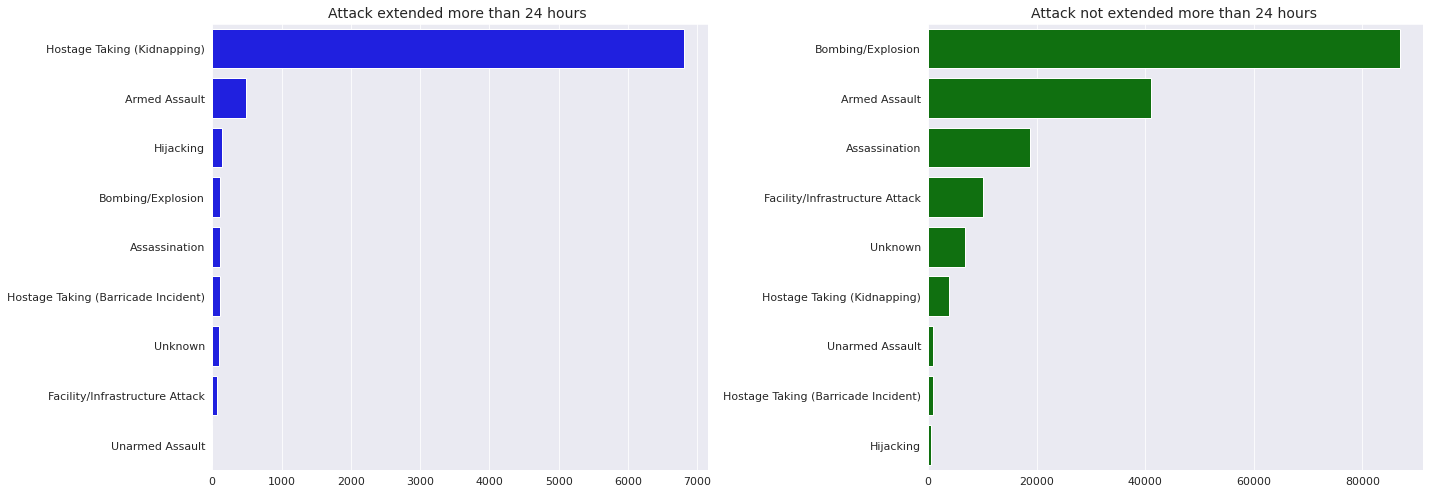

In [92]:
extended_attack_df = GTA_df_new[GTA_df_new['extended'] == 1]
non_extended_attack_df = GTA_df_new[~ (GTA_df_new['extended'] == 1)]

plt.figure(figsize=(20, 7))
ax1 = plt.subplot(121)
sns.barplot(extended_attack_df['attack_type'].value_counts().values,extended_attack_df['attack_type'].value_counts().index, color='blue')
ax1.set_title('Attack extended more than 24 hours ',size = 14)
ax2 = plt.subplot(122)
sns.barplot(non_extended_attack_df['attack_type'].value_counts().values,non_extended_attack_df['attack_type'].value_counts().index, color='green')
ax2.set_title('Attack not extended more than 24 hours ',size = 14)
plt.tight_layout()
plt.show()

In [93]:
(extended_attack_df['attack_type'].value_counts()/len(extended_attack_df))*100

Hostage Taking (Kidnapping)            85.761089
Armed Assault                           6.060988
Hijacking                               1.789315
Bombing/Explosion                       1.449093
Assassination                           1.386089
Hostage Taking (Barricade Incident)     1.348286
Unknown                                 1.247480
Facility/Infrastructure Attack          0.932460
Unarmed Assault                         0.025202
Name: attack_type, dtype: float64

In [94]:
(non_extended_attack_df['attack_type'].value_counts()/len(non_extended_attack_df))*100

Bombing/Explosion                      51.097251
Armed Assault                          24.151857
Assassination                          11.072443
Facility/Infrastructure Attack          5.959778
Unknown                                 4.044513
Hostage Taking (Kidnapping)             2.303256
Unarmed Assault                         0.579047
Hostage Taking (Barricade Incident)     0.505564
Hijacking                               0.286290
Name: attack_type, dtype: float64

##### **Findings from the above graph**
* More than 85% of cases if an attack is extended more than 24 hours, are reported as Hostage Taking (Kidnapping).
* Followed by Armed Assault  with 6% of chances.
* Attacks by Unarmed Assault very rarely extend more than 24 hours.
* Hijacking ,Bombing/Explosion ,Assassination and Hostage Taking (Barricade Incident) have equal chances to extend more than in a day. (have <2% chances).
* If an attack does not extend more than 24 hours, approx. 50% of cases have been reported by Bombing/Explosion.
* Followed by Armed Assault with 24% ,Assassination with 11% 
* Unarmed Assault, Hostage Taking (Barricade Incident), and Hijacking are the rarely reported method for attacks within  24 hours.

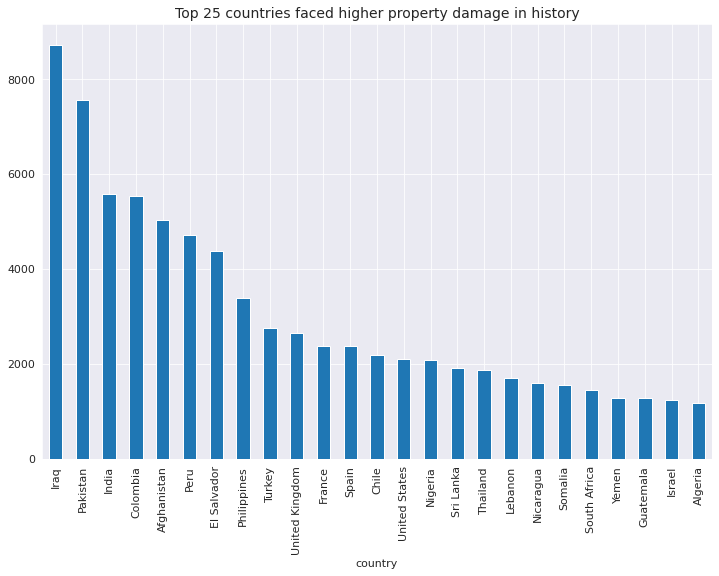

In [95]:
### top 25 countries faced higher property damage
plt.rcParams['figure.figsize'] = (12, 8)
property_damage = GTA_df_new[GTA_df_new.property  == 1] 
property_damage.groupby('country')['property'].count().sort_values(ascending  =False)[:25].plot(kind ='bar')
plt.title('Top 25 countries faced higher property damage in history', size = 14)
plt.show()

##### **Findings from the above graph**
* The most affected country Iraq facing higher property damage due to property gets damaged from fire and explosions in war during 2013 -17.
* Followed second targeted city in the world Pakisthan.
* India ,Colombia and Afghanistan are apprx.similar reported property damages.

## **Ask & answer questions**

#### Ask & answer questions
1. Which period of time had the highest number of attacks and which period had the lowest?
2. What percentage of total attacks had extended more than 24 hours?
3. Number of successful and unsuccessful accidents
4. Do the trend in attacks vary with respect to month?
5. What are the top 25 target countries in the world?
6. Identify the 50 targeted cities in the history
7. Top 10 active terrorist groups in the most affected city? 
8. Compare the outcomes (number of fatalities & wounds) from the above findings. Identify the years with the least & most casualties in the city. Discuss the reasons.
9. Comment on the global trend in terrorism with respect to the period of time.
10. Discuss the role of deadliest wars in the history with the help of appropriate visualization tools. For this purpose consider following wars
            a. Syrian Civil War, 
            b. Iraq War,
            c. Afghanistan War
            d. The War Against Boko Haram (Nigeria)
11. Which region was the most fallen victim of attacks? Which region has the lowest?
12. What are the regions containing the highest and the lowest casualties?. Compare casualties, the death toll, and number of wounds in each region.
13. Compare the trend in attack in each region with respect to the time?
14. Number of attacks VS success rate.
15. What kinds of weapons are used in terror attacks?
16. Who are the common victims of terror attacks?
17. Who are the top 25 active terror groups? 
18. Find out the targeted countries of the top 3 active groups in history. Comment out outcomes. 
19. Explore the variable 'extended' with respect to the method of attack

## **Summary and Conclusions**
#### **Insights:**
* There is a sudden hike in terrorist activities from 2012 compared to the previous years, reaching a peak in 2014 with 16796 attacks. 1971 is the year that had the least number of attacks (463) in the world.<br>

* Iraq is the most targeted country in history, followed by Pakistan, Afghanistan, India, Colombia, the Philippines, and Peru. Iraq alone was victimized more than 24,500 times throughout the time period (1970 – 2017).Since the most victimized countries are densely populated, the attacks in these countries claim more damage and lives.<br>
* Iraq, Afghanistan, Pakistan, Nigeria & Syria are severely victimized in the 20s. This period of time is famously known as the Syrian Civil War, Iraq War, Afghanistan War, The War Against Boko Haram.<br>
* The capital of the most affected country, Baghdad is found to be the most targeted city in the world, followed by Karachi in Pakisthan, Lima in Peru, and so on. Baghdad alone was targeted more than 7,500 times in history.<br>

* In Baghdad, the period of 2011 - 17 had a higher number of fatalities and wounds. Since the government is not able to find the terror group responsible for the majority of the attacks that happened in the city, we can see the evidence of wars in the specified period. The city has faced severe damages during this time due to the Iraq War which lasted until 2011 and subsequent insurgency and renewed war that lasted until 2017. The attacks started declining in 2017 mainly because of the territorial defeat of the Islamic State militant group. From 2003 - 2011 is showing up & a down trend in attacks due to the United States invasion of Iraq lasted from 2003-11.<br>
* All the three, the number of fatalities,number of wounded and total number of attacks are interconnected. The highest recorded war period 2013 - 17 had the highest number of fatalities and reported wounds in the world.<br>
* 